In [2]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from itertools import product
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from itertools import chain
import scipy.stats as stats
import warnings
from functools import reduce
import math

In [3]:
df_train = pd.read_csv("./adult.data", header=None)
df_test = pd.read_csv("./adult.test", header=None)

In [4]:
df_train.head()

0                  1       2           3   4                    5   \
0  39          State-gov   77516   Bachelors  13        Never-married   
1  50   Self-emp-not-inc   83311   Bachelors  13   Married-civ-spouse   
2  38            Private  215646     HS-grad   9             Divorced   
3  53            Private  234721        11th   7   Married-civ-spouse   
4  28            Private  338409   Bachelors  13   Married-civ-spouse   

                   6               7       8        9     10  11  12  \
0        Adm-clerical   Not-in-family   White     Male  2174   0  40   
1     Exec-managerial         Husband   White     Male     0   0  13   
2   Handlers-cleaners   Not-in-family   White     Male     0   0  40   
3   Handlers-cleaners         Husband   Black     Male     0   0  40   
4      Prof-specialty            Wife   Black   Female     0   0  40   

               13      14  
0   United-States   <=50K  
1   United-States   <=50K  
2   United-States   <=50K  
3   United-States   <=50K  
4            Cuba   <=50K

In [5]:
df_train.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "salary"]
df_test.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "salary"]

In [6]:
df = pd.concat([df_train, df_test])

In [7]:
X = df.drop(["salary"], axis=1)

In [8]:
y = df.salary

In [9]:
X.head()

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  
0          2174             0              40   United-States  
1             0             0              13   United-States  
2             0             0              40   United-States  
3             0             0              40   United-States  
4             0             0              40            Cuba

In [10]:
y.head()

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: salary, dtype: object

## Utils

In [11]:
def analyze_categorical_variables(data):
    """
    Analyzes categorical variables in a DataFrame.

    Args:
        data (DataFrame): The DataFrame containing the data.

    Returns:
        dict: A dictionary where the different categories, their absolute frequencies,
              and relative frequencies are stored.
    """
    # Initialize a dictionary to store the results
    results = {}

    # Generate a list of the variable names
    variables = list(data.columns)

    # Select the numerical columns in the DataFrame
    numerical = data.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns

    # Select the categorical columns in the DataFrame
    categorical = [variable for variable in variables if variable not in numerical]

    # Iterate through the categorical variables
    for category in categorical:
        # Check if the categorical variable exists in the DataFrame
        if category in data.columns:
            # Create a summary DataFrame for the categorical variable
            summary = pd.DataFrame({
                'n': data[category].value_counts(),                # Count of frequencies
                '%': data[category].value_counts(normalize=True)  # Percentage of frequencies
            })
            results[category] = summary  # Store the summary in the dictionary
        else:
            # If the variable does not exist in the data, store None in the dictionary
            results[category] = None

    return results

In [12]:
def count_unique_values(data):
    """
    Counts unique values in each numeric variable of a DataFrame.

    Args:
        data (DataFrame): The DataFrame containing the data.

    Returns:
        DataFrame: A DataFrame with the variables and the number of unique values in each.
    """
    # Select the numerical columns in the DataFrame
    numerical = data.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64'])

    # Calculate the number of unique values in each numerical column
    results = numerical.apply(lambda x: len(x.unique()))

    # Create a DataFrame with the results
    result = pd.DataFrame({'Column': results.index, 'Unique': results.values})

    return result


In [13]:
def freq_numeric_variables(data, numeric_as_categorical):
    """
    Calculates the frequencies of different values of numeric variables (treated as categorical).
    
    Args:
        data: DataFrame containing the data.
        numeric_as_categorical: List of names of numeric variables to analyze.
    
    Returns:
        dict: A dictionary where the keys are the names of the numeric variables and the values are 
              DataFrames with the summary of frequencies and percentages.
    """
    results = {}

    for variable in numeric_as_categorical:
        # Check if the variable exists in the DataFrame
        if variable in data.columns:
            # Create a summary DataFrame for the variable
            summary = pd.DataFrame({
                'n': data[variable].value_counts(),               # Frequency count
                '%': data[variable].value_counts(normalize=True) # Percentage frequency
            })
            results[variable] = summary  # Store the summary in the dictionary
        else:
            # If the variable doesn't exist in the data, store None in the dictionary
            results[variable] = None

    return results


In [14]:
def missing_pattern(data_input):
    """
    Visualizes a heatmap showing the correlation matrix of missing values in the dataset.

    Args:
        data_input (DataFrame): The input dataset.
    """
    # Calculate a correlation matrix of missing values for columns with at least one missing value
    correlation_matrix = data_input[data_input.columns[data_input.isna().sum() > 0]].isna().corr()
    
    # Create a mask to hide the upper triangle of the matrix (symmetry)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Set the figure size and font scale for the plot
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=0.6)
    
    # Generate a heatmap of the missing value correlation matrix
    # 'annot=True' shows the values inside the cells
    # 'cmap="coolwarm"' sets the color palette for the heatmap
    # 'fmt=".2f"' formats the values as floats with two decimal places
    # 'cbar=True' shows the color bar (scale) on the right
    # 'mask=mask' applies the mask to hide the upper triangle
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, mask=mask)
    
    # Set the plot title
    plt.title("Correlation matrix of missing values")
    plt.show()


In [15]:
cat_var = ["workclass", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "native_country"]
cont_var = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]

In [16]:
categorical = analyze_categorical_variables(X)
for key in categorical:
    print(key)
    print(categorical[key])
    print("\n")

workclass
                      n         %
workclass                        
Private           33906  0.694198
Self-emp-not-inc   3862  0.079071
Local-gov          3136  0.064207
?                  2799  0.057307
State-gov          1981  0.040559
Self-emp-inc       1695  0.034704
Federal-gov        1432  0.029319
Without-pay          21  0.000430
Never-worked         10  0.000205


education
                  n         %
education                    
HS-grad       15784  0.323164
Some-college  10878  0.222718
Bachelors      8025  0.164305
Masters        2657  0.054400
Assoc-voc      2061  0.042197
11th           1812  0.037099
Assoc-acdm     1601  0.032779
10th           1389  0.028439
7th-8th         955  0.019553
Prof-school     834  0.017075
9th             756  0.015478
12th            657  0.013452
Doctorate       594  0.012162
5th-6th         509  0.010421
1st-4th         247  0.005057
Preschool        83  0.001699


marital-status
                           n         %
marital-

A lot of categories are unblanced. It is necessary to regroup some variables according to more general entities

In [17]:
def simplify_workclass(x):
    x = str(x).strip()
    if x in ["Local-gov", "State-gov", "Federal-gov"]:
        return "Government"
    elif x in ["Self-emp-not-inc", "Self-emp-inc"]:
        return "Self-emp"
    elif x in ["Without-pay", "Never-worked"]:
        return "Other"
    elif x == "Private":
        return "Private"
    elif x == "?":
        return np.nan
    else:
        return np.nan

X["workclass"] = X["workclass"].apply(simplify_workclass)


def simplify_marital_status(x):
    x = str(x).strip()
    if x in ["Divorced", "Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse"]:
        return "Before-Married"
    else:
        return x

X["marital-status"] = X["marital-status"].apply(simplify_marital_status)
    
education_mapping = {
    "Preschool": "Elementary",
    "1st-4th": "Elementary",
    "5th-6th": "Elementary",
    "7th-8th": "Elementary",
    
    "9th": "MiddleHS",
    "10th": "MiddleHS",
    "11th": "MiddleHS",
    "12th": "MiddleHS",
    
    "HS-grad": "HS-grad",
    
    "Some-college": "PostHS",
    "Assoc-voc": "PostHS",
    "Assoc-acdm": "PostHS",
    
    "Bachelors": "HigherEd",
    "Prof-school": "HigherEd",
    "Masters": "HigherEd",
    "Doctorate": "HigherEd"
}

X["education"] = X["education"].str.strip().map(education_mapping)

In [18]:
## Remove Nation because Race express the same??

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# 1) Tabla de contingencia
contingency = pd.crosstab(X["race"], X["native_country"])

# 2) Test chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi2:", chi2)
print("p-value:", p)

# 3) Cramér's V
n = contingency.values.sum()
phi2 = chi2 / n
r, k = contingency.shape
cramers_v = np.sqrt(phi2 / (min(r-1, k-1)))
print("Cramer's V:", cramers_v)
## V de Cramer mayor a 0.4 --> redundancia --> no la quito, solo cambio todos los países a EEUU / no-EEUU

Chi2: 31516.904478019
p-value: 0.0
Cramer's V: 0.4016474947444511


In [19]:
def simplify_native_country(x):
    x = str(x).strip()
    if x in ["United-States"]:
        return "United-States"
    elif x == "?":
        return np.nan
    else:
        return "Non-EEUU"

X["native_country"] = X["native_country"].apply(simplify_native_country)

def simplify_race(x):
    x = str(x).strip()
    if x in ["White"]:
        return "White"
    else:
        return "Non-White"

X["race"] = X["race"].apply(simplify_race)


In [20]:
X

age   workclass  fnlwgt education  education-num      marital-status  \
0       39  Government   77516  HigherEd             13       Never-married   
1       50    Self-emp   83311  HigherEd             13  Married-civ-spouse   
2       38     Private  215646   HS-grad              9      Before-Married   
3       53     Private  234721  MiddleHS              7  Married-civ-spouse   
4       28     Private  338409  HigherEd             13  Married-civ-spouse   
...    ...         ...     ...       ...            ...                 ...   
16276   39     Private  215419  HigherEd             13      Before-Married   
16277   64         NaN  321403   HS-grad              9      Before-Married   
16278   38     Private  374983  HigherEd             13  Married-civ-spouse   
16279   44     Private   83891  HigherEd             13      Before-Married   
16280   35    Self-emp  182148  HigherEd             13  Married-civ-spouse   

               occupation     relationship       race      sex  capital_gain  \
0            Adm-clerical    Not-in-family      White     Male          2174   
1         Exec-managerial          Husband      White     Male             0   
2       Handlers-cleaners    Not-in-family      White     Male             0   
3       Handlers-cleaners          Husband  Non-White     Male             0   
4          Prof-specialty             Wife  Non-White   Female             0   
...                   ...              ...        ...      ...           ...   
16276      Prof-specialty    Not-in-family      White   Female             0   
16277                   ?   Other-relative  Non-White     Male             0   
16278      Prof-specialty          Husband      White     Male             0   
16279        Adm-clerical        Own-child  Non-White     Male          5455   
16280     Exec-managerial          Husband      White     Male             0   

       capital_loss  hours_per_week native_country  
0                 0              40  United-States  
1                 0              13  United-States  
2                 0              40  United-States  
3                 0              40  United-States  
4                 0              40       Non-EEUU  
...             ...             ...            ...  
16276             0              36  United-States  
16277             0              40  United-States  
16278             0              50  United-States  
16279             0              40  United-States  
16280             0              60  United-States  

[48842 rows x 14 columns]

In [21]:
count_unique_values(X)

Column  Unique
0             age      74
1          fnlwgt   28523
2   education-num      16
3    capital_gain     123
4    capital_loss      99
5  hours_per_week      96

fnlwgt is a socioeconomic variable. Having this variable in the analysis will greatly improve the results but we won't get the intricacies of the data

In [22]:
X.drop(["fnlwgt"],inplace=True, axis=1)

In [23]:
freq_numeric_variables(X, cont_var)

{'age':         n         %
 age                
 36   1348  0.027599
 35   1337  0.027374
 33   1335  0.027333
 23   1329  0.027210
 31   1325  0.027128
 ..    ...       ...
 88      6  0.000123
 85      5  0.000102
 87      3  0.000061
 89      2  0.000041
 86      1  0.000020
 
 [74 rows x 2 columns],
 'fnlwgt': None,
 'capital_gain':                   n         %
 capital_gain                 
 0             44807  0.917387
 15024           513  0.010503
 7688            410  0.008394
 7298            364  0.007453
 99999           244  0.004996
 ...             ...       ...
 2387              1  0.000020
 1111              1  0.000020
 7262              1  0.000020
 1731              1  0.000020
 6612              1  0.000020
 
 [123 rows x 2 columns],
 'capital_loss':                   n         %
 capital_loss                 
 0             46560  0.953278
 1902            304  0.006224
 1977            253  0.005180
 1887            233  0.004770
 2415             72  0.00147

All variables should be categories, as they do not represent data consistently

Now we will replace '?' by NA so we can analyse missing data:

In [24]:
X.replace('?', np.nan, inplace=True)
X.replace(' ?', np.nan, inplace=True)

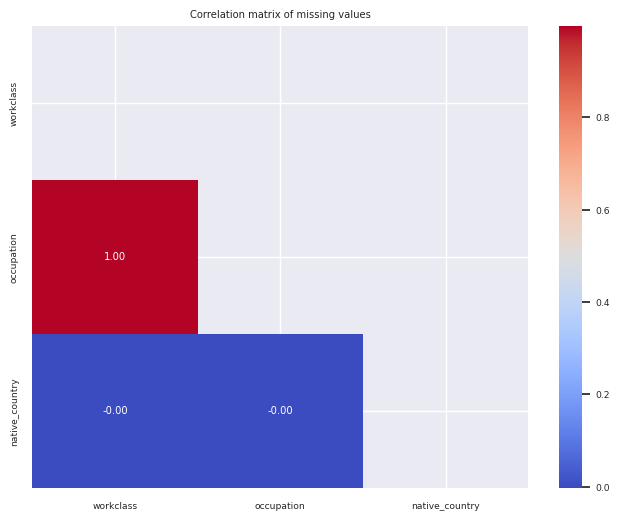

In [25]:
missing_pattern(X)

In [26]:
## TODO
# Transform "continuous" data to "discrete" data
# Impute Data

<Axes: ylabel='Density'>

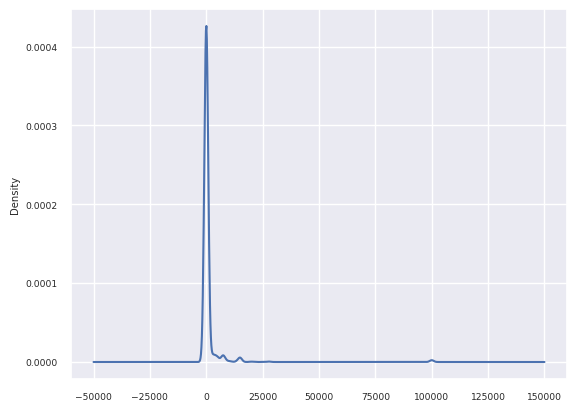

In [27]:
X["capital_gain"].plot.density()

<Axes: ylabel='Density'>

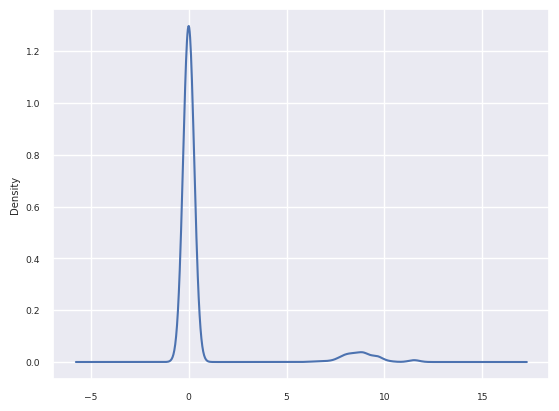

In [28]:
np.log1p(X["capital_gain"]).plot.density()

<Axes: ylabel='Density'>

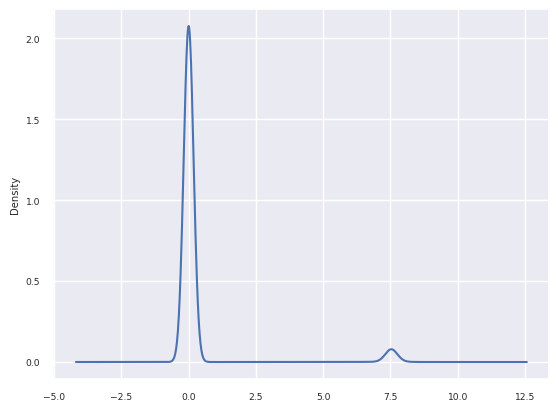

In [29]:
np.log1p(X["capital_loss"]).plot.density()

In [30]:
def make_discrete(x):
    return "Yes" if np.log1p(x) > 2.5 else "No"

X["capital_loss"] = X["capital_loss"].apply(make_discrete)
X["capital_gain"] = X["capital_gain"].apply(make_discrete)

In [31]:
analyze_categorical_variables(X)

{'workclass':                 n         %
 workclass                  
 Private     33906  0.736399
 Government   6549  0.142237
 Self-emp     5557  0.120692
 Other          31  0.000673,
 'education':                 n         %
 education                  
 HS-grad     15784  0.323164
 PostHS      14540  0.297695
 HigherEd    12110  0.247942
 MiddleHS     4614  0.094468
 Elementary   1794  0.036731,
 'marital-status':                         n         %
 marital-status                     
 Married-civ-spouse  22379  0.458192
 Never-married       16117  0.329982
 Before-Married      10346  0.211826,
 'occupation':                       n         %
 occupation                       
 Prof-specialty     6172  0.134078
 Craft-repair       6112  0.132774
 Exec-managerial    6086  0.132210
 Adm-clerical       5611  0.121891
 Sales              5504  0.119566
 Other-service      4923  0.106945
 Machine-op-inspct  3022  0.065649
 Transport-moving   2355  0.051159
 Handlers-cleaners  2072  0

In [32]:
X.apply(pd.isna).sum()

age                  0
workclass         2799
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
dtype: int64

In [33]:
def ImputacionCuali(var, tipo):
    """
    Esta función realiza la imputación de valores faltantes en una variable cualitativa.

    Datos de entrada:
    - var: Serie de datos cualitativos con valores faltantes a imputar.
    - tipo: Tipo de imputación ('moda' o 'aleatorio').

    Datos de salida:
    - Una nueva serie con valores faltantes imputados.
    """

    # Realiza una copia de la variable para evitar modificar la original
    vv = var.copy()

    if tipo == 'moda':
        # Imputa los valores faltantes con la moda (valor más frecuente)
        frecuencias = vv[~vv.isna()].value_counts()
        moda = frecuencias.index[np.argmax(frecuencias)]
        vv[vv.isna()] = moda
    elif tipo == 'aleatorio':
        # Imputa los valores faltantes de manera aleatoria a partir de valores no faltantes
        vv[vv.isna()] = np.random.choice(vv[~vv.isna()], size=np.sum(vv.isna()), replace=True)

    return vv

X["workclass"] = ImputacionCuali(X["workclass"], "moda")
X["occupation"] = ImputacionCuali(X["occupation"], "aleatorio")
X["native_country"] = ImputacionCuali(X["native_country"], "moda")

In [34]:
X.apply(pd.isna).sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64

In [35]:
def Vcramer(v, target):
    """
    Calcula el coeficiente V de Cramer entre dos variables. Si alguna de ellas es continua, la discretiza.

    Datos de entrada:
    - v: Serie de datos categóricos o cuantitativos.
    - target: Serie de datos categóricos o cuantitativos.

    Datos de salida:
    - Coeficiente V de Cramer que mide la asociación entre las dos variables.
    """

    if v.dtype == 'float64' or v.dtype == 'int64':
        # Si v es numérica, la discretiza en intervalos y rellena los valores faltantes
        p = sorted(list(set(v.quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]))))
        v = pd.cut(v, bins=p)
        v = v.fillna(v.min())

    if target.dtype == 'float64' or target.dtype == 'int64':
        # Si target es numérica, la discretiza en intervalos y rellena los valores faltantes
        p = sorted(list(set(target.quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]))))
        target = pd.cut(target, bins=p)
        target = target.fillna(target.min())

    # Calcula una tabla de contingencia entre v y target
    tabla_cruzada = pd.crosstab(v, target)

    # Calcula el chi-cuadrado y el coeficiente V de Cramer
    chi2 = chi2_contingency(tabla_cruzada)[0]
    n = tabla_cruzada.sum().sum()
    v_cramer = np.sqrt(chi2 / (n * (min(tabla_cruzada.shape) - 1)))

    return v_cramer

    
def graficoVcramer(matriz, target):
    """
    Genera un gráfico de barras horizontales que muestra el coeficiente V de Cramer entre cada columna de matriz y la variable target.

    Datos de entrada:
    - matriz: DataFrame con las variables a comparar.
    - target: Serie de la variable objetivo (categórica).

    Datos de salida:
    - Gráfico de barras horizontales que muestra el coeficiente V de Cramer para cada variable.
    """

    # Calcula el coeficiente V de Cramer para cada columna de matriz y target
    salidaVcramer = {x: Vcramer(matriz[x], target) for x in matriz.columns}

    # Ordena los resultados en orden descendente por el coeficiente V de Cramer
    sorted_data = dict(sorted(salidaVcramer.items(), key=lambda item: item[1], reverse=True))

    # Crea el gráfico de barras horizontales
    plt.figure(figsize=(10, 6))
    plt.barh(list(sorted_data.keys()), list(sorted_data.values()), color='skyblue')
    plt.xlabel('V de Cramer')
    plt.show()

def correlaciones(datos_input):
    columns = datos_input.columns
    n = len(columns)
    correlation_matrix = pd.DataFrame(np.zeros((n, n)), columns=columns,
    index=columns)
    for i in range(n):
        for j in range(i, n):
            v = Vcramer(datos_input.iloc[:, i], datos_input.iloc[:, j])
            correlation_matrix.iloc[i, j] = v
            correlation_matrix.iloc[j, i] = v
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=0.6)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
    fmt=".2f", cbar=True, mask=mask)
    plt.title("Matriz de correlación de valores de V de Cramer")
    plt.show()

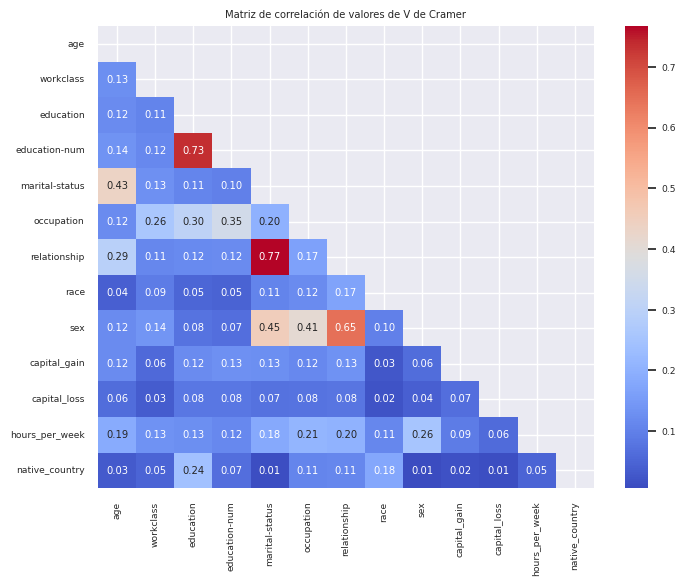

In [36]:
correlaciones(X)

In [37]:
VCramer = []

for variable in X.columns:
    v_cramer = Vcramer(X[variable], y)
    VCramer.append({
        'Variable': variable,
        'Objetivo': y.name,
        'Vcramer': v_cramer
    })

VCramer = pd.DataFrame(VCramer)
display(VCramer)

Variable Objetivo   Vcramer
0              age   salary  0.178936
1        workclass   salary  0.075560
2        education   salary  0.197178
3    education-num   salary  0.198290
4   marital-status   salary  0.316592
5       occupation   salary  0.191131
6     relationship   salary  0.262511
7             race   salary  0.083811
8              sex   salary  0.214634
9     capital_gain   salary  0.265930
10    capital_loss   salary  0.136014
11  hours_per_week   salary  0.157380
12  native_country   salary  0.038532

In [38]:
X.drop(["relationship", "education", "race", "native_country", "workclass"], axis=1, inplace=True)

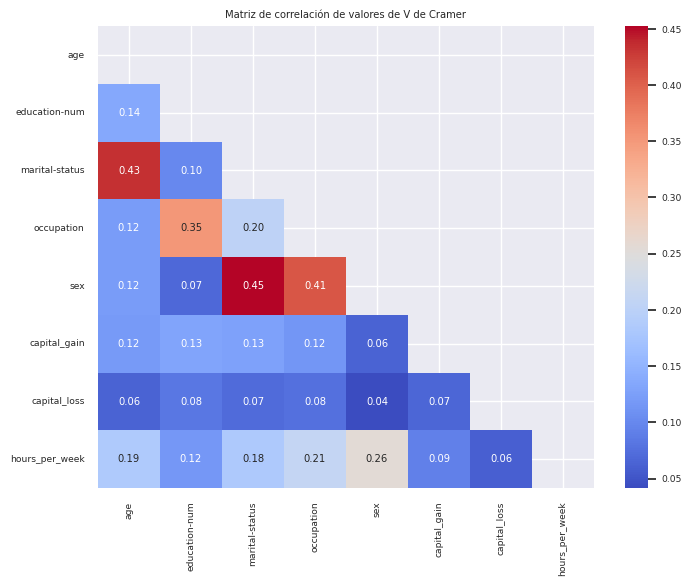

In [39]:
correlaciones(X) ## variables now are less dependent from each other

In [40]:
VCramer = []

for variable in X.columns:
    v_cramer = Vcramer(X[variable], y)
    VCramer.append({
        'Variable': variable,
        'Objetivo': y.name,
        'Vcramer': v_cramer
    })

VCramer = pd.DataFrame(VCramer)
display(VCramer) ## Keep variables with good VCramer

Variable Objetivo   Vcramer
0             age   salary  0.178936
1   education-num   salary  0.198290
2  marital-status   salary  0.316592
3      occupation   salary  0.191131
4             sex   salary  0.214634
5    capital_gain   salary  0.265930
6    capital_loss   salary  0.136014
7  hours_per_week   salary  0.157380

In [41]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


def evaluar_modelos(X, y, cv_splits=5, random_state=42):
    # 1) Identificar numéricas y categóricas automáticamente
    num_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns
    cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns

    print("Numéricas:", list(num_cols))
    print("Categóricas:", list(cat_cols))

    # 2) Preprocesador común
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ]
    )

    # 3) Modelos a comparar
    modelos = {
        "LogisticRegression": LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            n_jobs=-1
        ),
        "SVC_RBF": SVC(
            kernel="rbf",
            probability=True,            # necesario para roc_auc
            class_weight="balanced",
            random_state=random_state
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=300,
            random_state=random_state,
            n_jobs=-1
        ),
        "GradientBoosting": GradientBoostingClassifier(
            random_state=random_state
        ),
    }

    # 4) Métricas
    scoring = {
        "accuracy": "accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
        "roc_auc": "roc_auc",
    }

    cv = StratifiedKFold(
        n_splits=cv_splits,
        shuffle=True,
        random_state=random_state
    )

    resultados = []

    for nombre, modelo in modelos.items():
        print(f"Entrenando modelo: {nombre}")

        pipe = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("clf", modelo),
        ])

        cv_result = cross_validate(
            pipe,
            X,
            y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            return_train_score=False
        )

        for metrica in scoring.keys():
            scores = cv_result[f"test_{metrica}"]
            resultados.append({
                "modelo": nombre,
                "metrica": metrica,
                "media": np.mean(scores),
                "std": np.std(scores),
            })

    resultados_df = pd.DataFrame(resultados)
    tabla_pivot = resultados_df.pivot(
        index="modelo",
        columns="metrica",
        values="media"
    )

    return resultados_df, tabla_pivot

In [42]:
X.shape

(48842, 8)

In [43]:
y = y.str.replace(".", "")

LogisticRegression
RandomForest
GradientBoosting


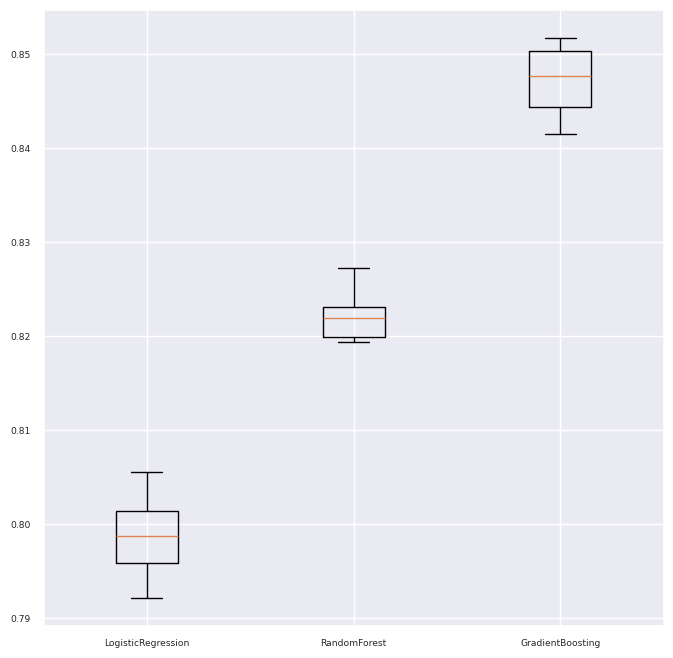

In [44]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
results = []
names = []
def boxplots_algorithms(results, names):
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()
random_state=123

num_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns

# 2) Preprocesamiento común para todos los modelos
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

modelos = {
        "LogisticRegression": LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            n_jobs=-1
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=300,
            random_state=random_state,
            n_jobs=-1
        ),
        "GradientBoosting": GradientBoostingClassifier(
            random_state=random_state
        ),
    }

for name, model in modelos.items():
    print(name)
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        (name, model)
    ])
    score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=random_state))
    results.append(score)
    names.append(name)

boxplots_algorithms(results, names)

In [57]:
from sklearn.model_selection import train_test_split
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)
X = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

salary
<=50K    0.760807
>50K     0.239193
Name: proportion, dtype: float64
salary
<=50K    0.760364
>50K     0.239636
Name: proportion, dtype: float64


/tmp/ipykernel_5877/518779785.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values, res_5.values], labels = ['res_1','res_2','res_3','res_4', 'res_5'])


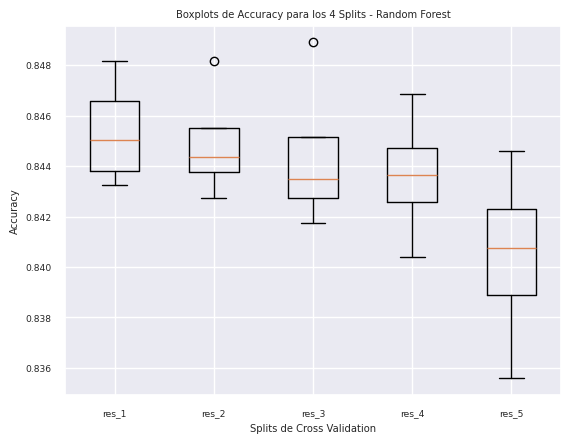

NameError: name 'accuracy_score' is not defined

In [59]:
seed=123
params = {
    'n_estimators' : [100,150,200],
    'max_depth': [15, 20, 30],
    'bootstrap': [True, False],
    'min_samples_leaf' :  [0.01, 0.1, 0.2, 0.3],
    'min_samples_split':  [0.01, 0.1, 0.2, 0.3],
    'criterion': ["gini", "entropy"],
    'max_features' :["sqrt", "log2", None]
}

scoring_metrics = ['accuracy']

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=seed), param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_rf.fit(X_train, y_train)


params = {
    'min_samples_leaf' :  [0.001, 0.005, 0.01, 0.015, 0.05],
    'min_samples_split':  [0.001, 0.005, 0.01, 0.015, 0.05],
}

scoring_metrics = ['accuracy']

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(n_estimators=200, max_depth=15, bootstrap=False,
                                                               criterion='entropy', max_features='sqrt', random_state=seed),
                              param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_rf.fit(X_train, y_train)
results_rf = pd.DataFrame(grid_search_rf.cv_results_)

results_rf = pd.DataFrame(grid_search_rf.cv_results_)
sorted_results_rf = results_rf.sort_values(by='mean_test_accuracy', ascending=False)

res_1 = sorted_results_rf[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = sorted_results_rf[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = sorted_results_rf[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = sorted_results_rf[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = sorted_results_rf[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]

sorted_results_rf_show = sorted_results_rf[["params", "mean_test_accuracy", "std_test_accuracy", "rank_test_accuracy"]]
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values, res_5.values], labels = ['res_1','res_2','res_3','res_4', 'res_5'])
plt.title('Boxplots de Accuracy para los 4 Splits - Random Forest')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

alternative_rf = grid_search_rf.best_estimator_.fit(X_train, y_train)
y_predict_train_rf = alternative_rf.predict(X_train)

In [1]:
from sklearn.metrics import accuracy_score
acc_rf_train = (accuracy_score(y_true=y_train, y_pred=y_predict_train_rf))

y_predict_rf = alternative_rf.predict(X_test)
acc_rf_test = (accuracy_score(y_true=y_test, y_pred=y_predict_rf))

print("Accuracy Train: %.2f" %acc_rf_train)
print("Accuracy Test: %.2f"%acc_rf_test)

NameError: name 'y_train' is not defined

In [62]:
## 0.85 in each dataset means that the model do not have overfitting and that variance is controlled, but the training data must be improved so the training goes better and more samples can be correctly classified
## We are going to perform dimensionality reduction to see what might be happening --> PCA no because there is cualitative variables --> we perform FAMD

In [59]:
X.dtypes

age                int64
education-num      int64
marital-status    object
occupation        object
sex               object
capital_gain      object
capital_loss      object
hours_per_week     int64
dtype: object

In [60]:
import prince

X_new = X.astype({'age': 'float64', "education-num": "float64"})

In [66]:
import prince
import pandas as pd

famd = prince.FAMD(
    n_components=2,
    n_iter=3,
    random_state=42
)

famd = famd.fit(X_new)

In [67]:
famd.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              5.873         1.72%                      1.72%
1              3.548         1.04%                      2.76%

In [68]:
famd.row_coordinates(X_new).head()


component         0         1
0         -0.274213  0.873373
1         -0.252399  5.344598
2         -0.420918 -1.775590
3          1.400743 -2.613873
4         -0.294497  0.879322

In [69]:
famd.column_coordinates_

component              0         1
variable                          
age             0.069443  0.054010
education-num   0.022472  0.085161
capital_gain    0.055584  0.124076
capital_loss    0.017385  0.006739
hours_per_week  0.381776  0.510702
marital-status  0.512626  0.117048
occupation      0.439249  0.347003
sex             0.553962  0.069841

In [73]:
import altair as alt
alt.data_transformers.disable_max_rows()

famd.plot(
    X_new,
    x_component=0,
    y_component=1
)

/home/eprdz/anaconda3/lib/python3.10/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/eprdz/anaconda3/lib/python3.10/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [79]:
famd.column_contributions_.style.format('{:.3%}')


In [80]:
## Parece que solo hay en realidad 5 variables que realmente tengan importancia: "sex", "occupation", "hours_per_week". "capital_gain" y "marital_status"

In [ ]:
## TODO: use SMOTE and SHAP